In [0]:
#importing required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

import torch 
import numpy as np 
import torchvision.transforms as transforms 
import torchvision 
import torch.nn.functional as F

In [2]:
from google.colab import auth
auth.authenticate_user()

import sys
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/Colab Notebooks/Resnet/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Resnet


In [0]:
class bottleNeck(torch.nn.Module):
    expansion = 4
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(bottleNeck,self).__init__()

        self.conv1 = torch.nn.Conv2d(input_planes,planes,kernel_size=1,stride=1)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.conv3 = torch.nn.Conv2d(planes,planes*self.expansion,kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(planes*self.expansion)
        self.dim_change = dim_change
    
    def forward(self,x):
        res = x
        
        output = F.relu(self.bn1(self.conv1(x)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)
        return output

In [3]:
sample = torch.randn(1,64,56,56)
sample.shape

torch.Size([1, 64, 56, 56])

In [151]:
sample.shape

torch.Size([1, 64, 56, 56])

In [0]:
block = bottleNeck

In [0]:
a = block(input_planes=64,planes =128,  stride=1)

In [160]:
sample=a(sample)
sample.shape

RuntimeError: ignored

In [0]:
b = block(input_planes=128, stride=1, dim_change=1)

In [148]:
sample = b(sample)
sample.shape

torch.Size([1, 256, 56, 56])

In [53]:
conv1 = torch.nn.Conv2d(64,64,kernel_size=1,stride=1, padding=0)
sample = conv1(sample)
sample.shape

torch.Size([1, 64, 56, 56])

In [54]:
conv2 = torch.nn.Conv2d(64,256,kernel_size=3,stride=1, padding=1)
sample = conv2(sample)
sample.shape

torch.Size([1, 256, 56, 56])

In [55]:
conv3 = torch.nn.Conv2d(256,128,kernel_size=1,stride=1, padding=0)
sample = conv3(sample)
sample.shape

torch.Size([1, 128, 56, 56])

In [102]:
a = baseBlock(input_planes = 64, planes = 64, stride=1, dim_change=None, expansion=4)

NameError: ignored

In [84]:
a(sample).shape

torch.Size([1, 128, 56, 56])

In [0]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.dim_change = dim_change
        
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn(self.conv1(x)))
        output = self.bn(self.conv2(output))

        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output = output + res
        output = F.relu(output)

        return output


### Test with network by network

In [0]:
conv1 = torch.nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3)
sample = torch.randn(1, 3, 224, 224)

In [58]:
sample = conv1(sample)
sample.shape

torch.Size([1, 64, 112, 112])

In [59]:
max1  = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
sample = max1(sample)
sample.shape

torch.Size([1, 64, 56, 56])

In [60]:
sample.shape

torch.Size([1, 64, 56, 56])

In [0]:
def _layer(block,planes,num_layers,stride=1, input_planes=64):
    dim_change = None
    input_planes = input_planes
    if stride!=1 or planes != input_planes*block.expansion:
        dim_change = torch.nn.Sequential(torch.nn.Conv2d(input_planes,planes*block.expansion,kernel_size=3,stride=1, padding=1),
                                         torch.nn.BatchNorm2d(planes*block.expansion))
    netLayers =[]
    netLayers.append(block(input_planes,planes,stride=stride,dim_change=dim_change))
    input_planes = planes * block.expansion
    for i in range(1,num_layers):
        netLayers.append(block(input_planes,planes))
        input_planes = planes * block.expansion

    return [torch.nn.Sequential(*netLayers), input_planes]

In [62]:
a=bottleNeck(input_planes=64,planes=256,stride=1, dim_change=None)

TypeError: ignored

In [37]:
a

[Sequential(
   (0): bottleNeck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (dim_change): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): bottleNeck(
     (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (bn2): BatchNorm2d(6

In [34]:
sample = a[0](sample)
print(sample.shape, a[1])

RuntimeError: ignored

In [0]:
b = _layer(bottleNeck,128,4, stride=2 , input_planes=a[1])

In [19]:
sample = b[0](sample)
print(sample.shape, b[1])

RuntimeError: ignored

In [0]:
c = _layer(baseBlock,256,2, stride=2 , input_planes=b[1])
sample = c[0](sample)
print(sample.shape, c[1])

torch.Size([1, 256, 14, 14]) 256


In [0]:
d = _layer(baseBlock,512,2, stride=2 , input_planes=c[1])
sample = d[0](sample)
print(sample.shape, d[1])

torch.Size([1, 512, 7, 7]) 512


In [0]:
sample = F.avg_pool2d(sample,4)
sample.shape

torch.Size([1, 512, 1, 1])

In [0]:
sample = sample.view(sample.size(0),-1)
sample.shape

torch.Size([1, 512])

In [0]:
sample = torch.nn.Linear(512*baseBlock.expansion,10)(sample)
sample.shape

torch.Size([1, 10])

### Consolidate above functions

In [0]:
class ResNet18(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet18,self).__init__()
        #according to research paper:
        self.input_planes = 64
        self.conv1 = torch.nn.Conv2d(3,64,kernel_size=7,stride=2, padding=3)
        self.bn1   = torch.nn.BatchNorm2d(64)
        self.max1  = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = _layer(block, 64, num_layers[0], stride=1, input_planes=self.input_planes)[0]
        self.input_plane1 = _layer(block, 64, num_layers[0], stride=1, input_planes=self.input_planes)[1]
        self.layer2 = _layer(block, 128, num_layers[1], stride=2, input_planes=self.input_plane1)[0]
        self.input_plane2 = _layer(block, 128, num_layers[1], stride=2, input_planes=self.input_plane1)[1]
        self.layer3 = _layer(block, 256, num_layers[2], stride=2, input_planes=self.input_plane2)[0]
        self.input_plane3 = _layer(block, 256, num_layers[2], stride=2, input_planes=self.input_plane2)[1]
        self.layer4 = _layer(block, 512, num_layers[3], stride=2, input_planes=self.input_plane3)[0]
        self.input_plane4 = _layer(block, 512, num_layers[3], stride=2, input_planes=self.input_plane3)[1]
        
        self.averagePool = torch.nn.AvgPool2d(kernel_size=4,stride=1)
        self.fc    =  torch.nn.Linear(512*block.expansion,classes)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        #print(x.shape)

        x = F.avg_pool2d(x,4)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x


In [0]:
sample = torch.randn(1, 3, 224, 224)

In [0]:
model =ResNet18(baseBlock,[2,2,2,2] )

In [0]:
model(sample)

torch.Size([1, 512, 7, 7])


tensor([[-0.2538, -0.1445, -0.1905, -0.0938, -0.3455,  0.3955,  0.2463, -0.7708,
         -0.2751,  0.3184]], grad_fn=<AddmmBackward>)

### Train with CiFar-10

In [0]:
transform = transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )

#Load train and test set:
train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainset = torch.utils.data.DataLoader(train,batch_size=128,shuffle=True)

test = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testset = torch.utils.data.DataLoader(test,batch_size=128,shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [0]:

net =  ResNet18(baseBlock,[2,2,2,2])
net.to(device)
costFunc = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.SGD(net.parameters(),lr=0.02,momentum=0.9)

In [0]:
for i,batch in enumerate(trainset):
    data,output = batch
    print(data.shape, output.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [0]:
for epoch in range(20):
    closs = 0
    for i,batch in enumerate(trainset,0):
        data,output = batch
        data,output = data.to(device),output.to(device)
        prediction = net(data)
        loss = costFunc(prediction,output)
        closs = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print every 1000th time
        if i%100 == 0:
            print('[%d  %d] loss: %.4f'% (epoch+1,i+1,closs/1000))
            closs = 0
    correctHits=0
    total=0
    for batches in testset:
        data,output = batches
        data,output = data.to(device),output.to(device)
        prediction = net(data)
        _,prediction = torch.max(prediction.data,1)  #returns max as well as its index
        total += output.size(0)
        correctHits += (prediction==output).sum().item()
    print('Accuracy on epoch ',epoch+1,'= ',str((correctHits/total)*100))

correctHits=0
total=0
for batches in testset:
    data,output = batches
    data,output = data.to(device),output.to(device)
    prediction = net(data)
    _,prediction = torch.max(prediction.data,1)  #returns max as well as its index
    total += output.size(0)
    correctHits += (prediction==output).sum().item()
print('Accuracy = '+str((correctHits/total)*100))

[1  1] loss: 0.0000
[1  101] loss: 0.0000
[1  201] loss: 0.0000
[1  301] loss: 0.0000
Accuracy on epoch  1 =  85.74000000000001
[2  1] loss: 0.0000
[2  101] loss: 0.0000
[2  201] loss: 0.0000
[2  301] loss: 0.0000
Accuracy on epoch  2 =  85.82
[3  1] loss: 0.0000
[3  101] loss: 0.0000
[3  201] loss: 0.0000
[3  301] loss: 0.0000
Accuracy on epoch  3 =  85.75
[4  1] loss: 0.0000
[4  101] loss: 0.0000
[4  201] loss: 0.0000
[4  301] loss: 0.0000
Accuracy on epoch  4 =  85.78
[5  1] loss: 0.0000
[5  101] loss: 0.0000
[5  201] loss: 0.0000
[5  301] loss: 0.0000
Accuracy on epoch  5 =  85.77
[6  1] loss: 0.0000
[6  101] loss: 0.0000
[6  201] loss: 0.0000
[6  301] loss: 0.0000
Accuracy on epoch  6 =  85.8
[7  1] loss: 0.0000
[7  101] loss: 0.0000
[7  201] loss: 0.0000
[7  301] loss: 0.0000
Accuracy on epoch  7 =  85.8
[8  1] loss: 0.0000
[8  101] loss: 0.0000
[8  201] loss: 0.0000
[8  301] loss: 0.0000
Accuracy on epoch  8 =  85.82
[9  1] loss: 0.0000
[9  101] loss: 0.0000
[9  201] loss: 0.000

airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8, device='cuda:0')


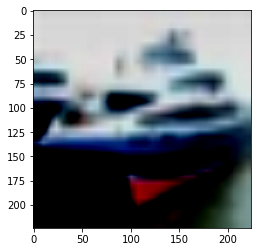

In [0]:
import matplotlib.pyplot as plt

for batches in testset:
    data,output = batches
    data,output = data.to(device),output.to(device)
    prediction = net(data)
    _,prediction = torch.max(prediction.data,1)  #returns max as well as its index
    break

print(prediction[1])
plt.imshow(data[1].to('cpu').permute(1, 2, 0).numpy())